In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from linearmodels import PanelOLS
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import shapiro, levene, bartlett, f_oneway, fligner
from statsmodels.graphics.gofplots import qqplot

In [4]:
data_basa = pd.read_excel('Х5.xlsx')

In [5]:
print(data_basa.shape)
print(data_basa['new_id'].nunique())

(256723, 18)
21743


In [6]:
data_basa.isnull().sum()
data_basa['Месяц'].unique() # месяцы нормальны по значения, но нужно проверить количество
data_grup_mag = data_basa.groupby('new_id', as_index=False)
print(data_grup_mag.agg({'Месяц':'count'})['Месяц'].unique()) # есть проблема

duplicate_ids = data_basa.groupby(['new_id', 'Месяц']).size().reset_index(name='count')
duplicate_ids = duplicate_ids[duplicate_ids['count'] > 1]['new_id'].unique()
print("new_id с повторяющимися месяцами:", duplicate_ids) # только один с ID 13842

[12 10  8 11  3  2  4  5  7  9  6 24]
new_id с повторяющимися месяцами: [13842]


In [7]:
print(data_basa[data_basa['Численность населения'] == 0].shape)

(13972, 18)


In [8]:
data = data_basa[(data_basa['Численность населения'] != 0)  & (data_basa['new_id'] != 13842)]

In [9]:
print(data.shape)
print(data_basa.shape)
print((256723-242727)/256723*100)

(242727, 18)
(256723, 18)
5.451790451186687


In [10]:
data.rename(columns={'Маркетплейсы, доставки, постаматы (100 м)' : 'пвз'}, inplace = True)
pd.options.mode.copy_on_write = True
data['Выручка'] = data['Средний чек']*data['Трафик']

C:\Users\Michael\AppData\Local\Temp\ipykernel_452\1023217886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'Маркетплейсы, доставки, постаматы (100 м)' : 'пвз'}, inplace = True)


In [11]:
df2 = data.groupby('new_id', as_index = False).agg({'Выручка':'mean', 'Трафик':'mean','Средний чек':'mean', 'пвз':'mean'}).copy()

In [12]:
def create_pvs_categories(value):
    if 0 == value:
        return 'нет'
    elif 1 == value:
        return 'мало'
    elif 2 <= value <= 6:
        return 'средне'
    else:
        return 'много'
df2['pvz_groups'] = df2['пвз'].apply(create_pvs_categories)

In [13]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
import numpy as np
import plotly.graph_objects as go
from scipy.stats import gaussian_kde

data_vr = df2['Выручка'].dropna()
plt.figure(figsize = (8,8))
# Статистики отдельно
mean_val = data_vr.mean()
median_val = data_vr.median()
std_val = data_vr.std()

print(f"Среднее:  {mean_val:.2f}")
print(f"Медиана:  {median_val:.2f}")
print(f"Ст. откл: {std_val:.2f}")

dark_green = "#088F34"   # тёмно-зелёный
light_green = "#A0C61A"  # светло-зелёный

# --- KDE + подгонка под счёт столбиков ---

# Сетка для KDE
x_grid = np.linspace(data_vr.min(), data_vr.max(), 400)
kde = gaussian_kde(data_vr)
y_kde = kde(x_grid)

# Считаем гистограмму, чтобы понять реальные высоты столбиков (в штуках)
hist_counts, bin_edges = np.histogram(data_vr, bins=60)
hist_max = hist_counts.max()

# Масштабируем KDE под высоту гистограммы (чисто визуально)
y_kde_scaled = y_kde * (hist_max / y_kde.max())

# --- Рисуем фигуру ---
fig = go.Figure()

# Гистограмма с количеством наблюдений
fig.add_trace(
    go.Histogram(
        x=data_vr,
        nbinsx=100,
        name="Распределение выручки",
        marker=dict(
            color=dark_green,
            line=dict(color=light_green, width=1)
        ),
        opacity=0.65,
        # по умолчанию histnorm=None → это именно количество
        # histnorm="count"
    )
)

# Сглаженная кривая сверху (подогнана по масштабу)
fig.add_trace(
    go.Scatter(
        x=x_grid,
        y=y_kde_scaled,
        mode="lines",
        name="Сглаженная форма распределения",
        line=dict(color=dark_green, width=3),
        fill="tozeroy",
        fillcolor="rgba(8,143,52,0.15)"
    )
)

# --- Оформление ---
fig.update_layout(
    title="Распределение выручки",
    xaxis_title="Выручка",
    yaxis_title="Количество наблюдений",
    template="simple_white",
    bargap=0.05,
)


fig.show()


Среднее:  59217274.13
Медиана:  50824193.71
Ст. откл: 31432852.89


<Figure size 800x800 with 0 Axes>

0.2431896481316179


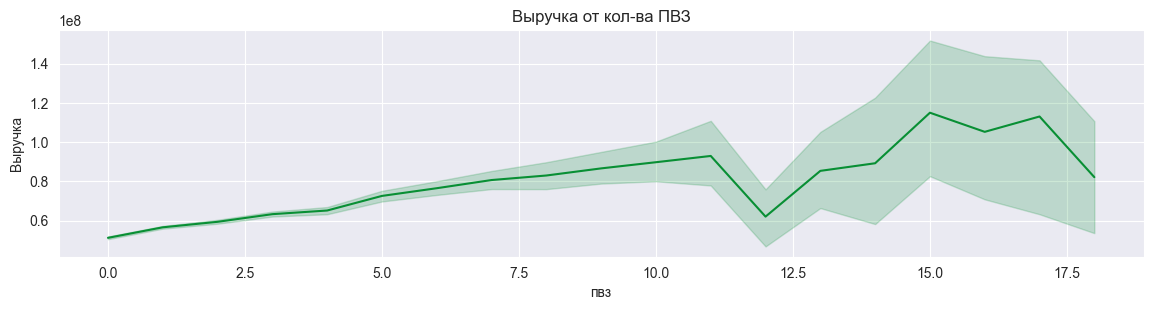

In [15]:
plt.figure(figsize = (14,10))

plt.subplot(3,1,1)
sns.lineplot(data = df2, x = 'пвз', y = 'Выручка', color = dark_green)
plt.title('Выручка от кол-ва ПВЗ')

print(df2['пвз'].corr(df2['Выручка']))

0.3036026231169117


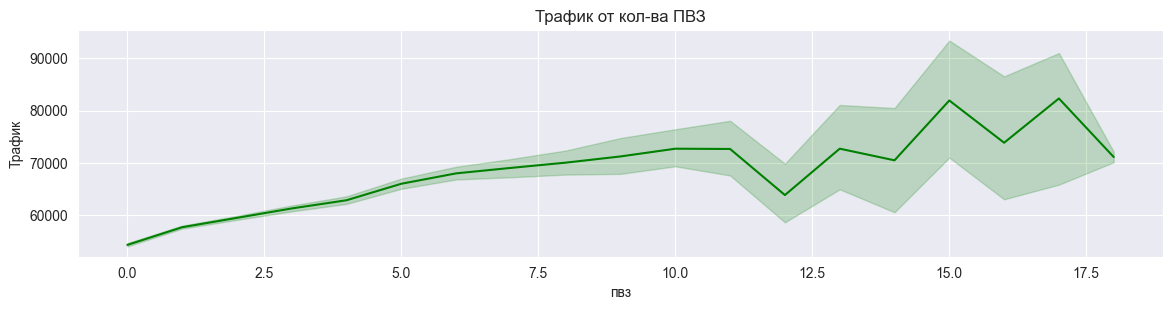

In [16]:
plt.show()
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
sns.lineplot(data=df2, x='пвз', y='Трафик', color='green')
plt.title('Трафик от кол-ва ПВЗ')

print(df2['пвз'].corr(df2['Трафик']))

0.1703361569383169


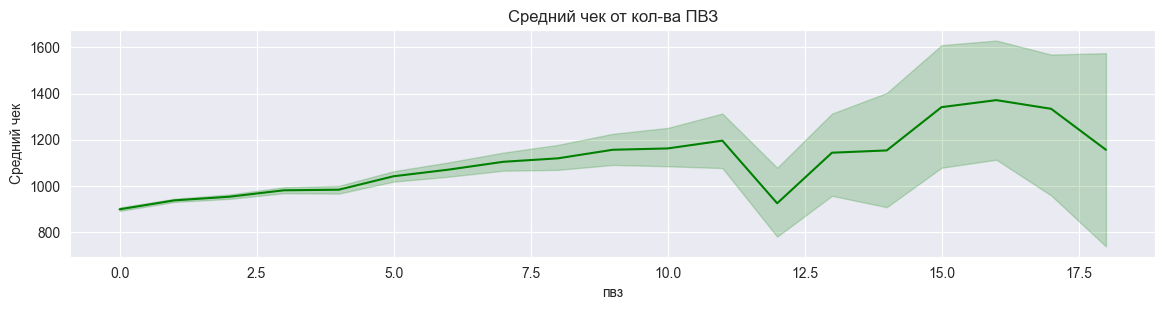

In [17]:
plt.show()
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
sns.lineplot(data=df2, x='пвз', y='Средний чек', color='green')
plt.title('Средний чек от кол-ва ПВЗ')

print(df2['пвз'].corr(df2['Средний чек']))

In [18]:
# проверка на нормальность
for group_name in ['нет', 'мало', 'средне', 'много']:
    group_data = df2[df2['pvz_groups'] == group_name]['Выручка']
    if len(group_data) > 3:
        stat, p = stats.shapiro(group_data)
        print(f"{group_name:15} | p = {p:.4f} | n = {len(group_data)} {group_data.mean()} {group_data.median()}")

нет             | p = 0.0000 | n = 5217 51252656.986325234 45461540.156775825
мало            | p = 0.0000 | n = 5813 56615578.83710856 49182950.70310234
средне          | p = 0.0000 | n = 8759 63571143.86699962 54396315.88794237
много           | p = 0.0000 | n = 740 84270675.87929028 73603240.39291485


C:\Users\Michael\PyCharmMiscProject\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5217.

C:\Users\Michael\PyCharmMiscProject\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5813.

C:\Users\Michael\PyCharmMiscProject\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8759.



In [19]:
group1 = df2[df2['pvz_groups'] == 'нет']['Выручка']
group2 = df2[df2['pvz_groups'] == 'мало']['Выручка']
group3 = df2[df2['pvz_groups'] == 'средне']['Выручка']
group4 = df2[df2['pvz_groups'] == 'много']['Выручка']

# Тест Левена на равенство дисперсий
levene_stat, levene_p = stats.levene(group1, group2, group3, group4)

if levene_p < 0.05:
    print(f"Дисперсии не равны! p-value = {levene_p}")
else:
    print("Дисперсии равны")

Дисперсии не равны! p-value = 1.4175567623277998e-96


C:\Users\Michael\AppData\Local\Temp\ipykernel_452\3677939263.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




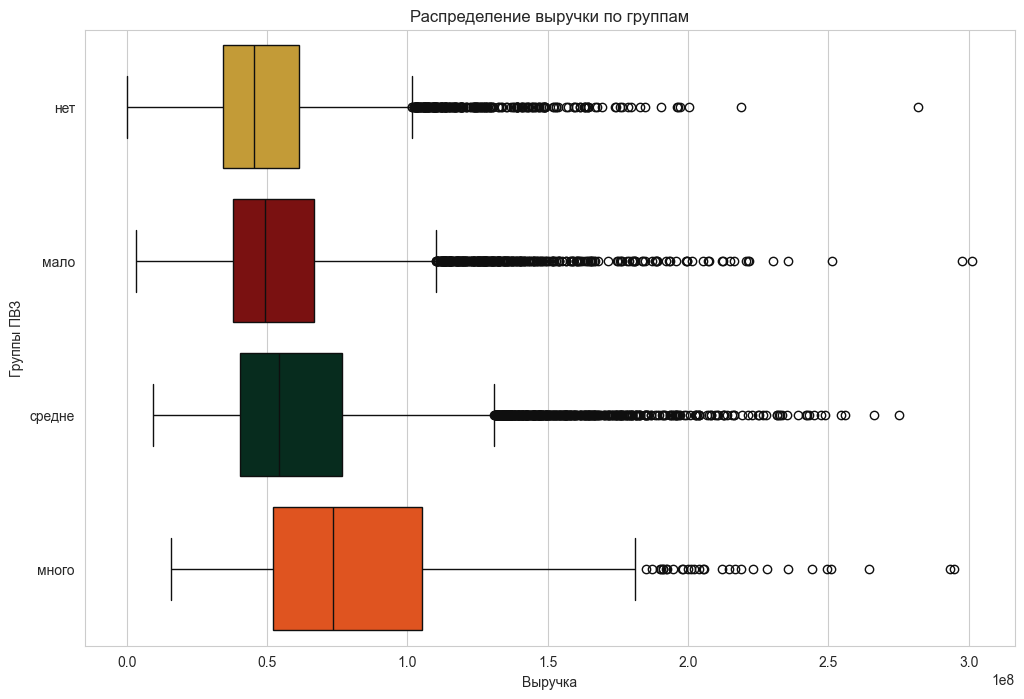

In [20]:
#боксплоты пвз-выручка
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.boxplot(data=df2, y='pvz_groups',
    x='Выручка',
    order=['нет', 'мало', 'средне', 'много'],
    orient='h',
    palette = ["#DAA520", "#8B0000", "#013220", "#FF4500"]
    )
plt.title('Распределение выручки по группам')
plt.ylabel('Группы ПВЗ')
plt.xlabel('Выручка')
plt.show()

C:\Users\Michael\AppData\Local\Temp\ipykernel_452\3772616949.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




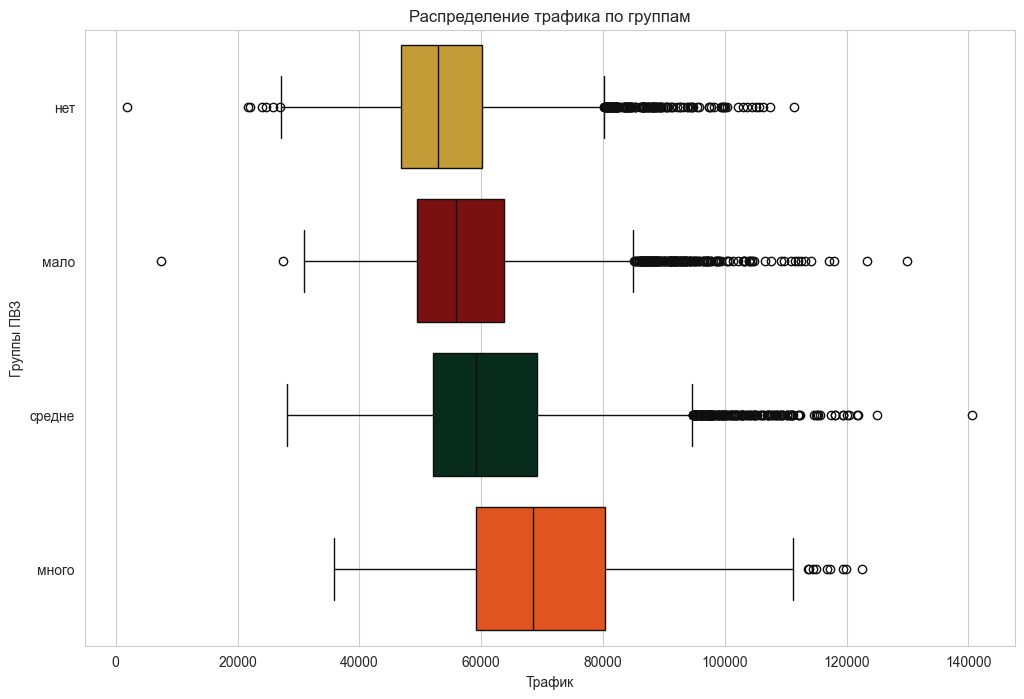

In [21]:
#боксплоты пвз-трафик
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.boxplot(data=df2, y='pvz_groups',
            x='Трафик',
            order=['нет', 'мало', 'средне', 'много'],
            orient='h',
            palette=["#DAA520", "#8B0000", "#013220", "#FF4500"]
            )
plt.title('Распределение трафика по группам')
plt.ylabel('Группы ПВЗ')
plt.xlabel('Трафик')
plt.show()

C:\Users\Michael\AppData\Local\Temp\ipykernel_452\2967494161.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




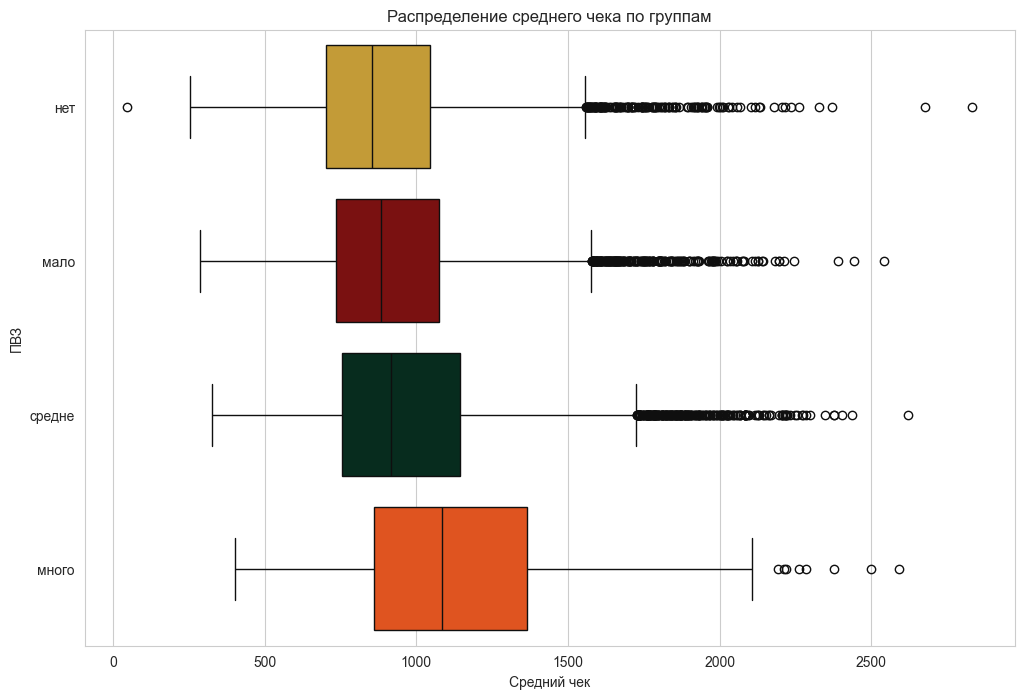

In [22]:
#боксплоты пвз-средний чек
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.boxplot(data=df2, y='pvz_groups',
    x='Средний чек',
    order=['нет', 'мало', 'средне', 'много'],
    orient='h',
    palette = ["#DAA520", "#8B0000", "#013220", "#FF4500"]
    )
plt.title('Распределение среднего чека по группам')
plt.ylabel('ПВЗ')
plt.xlabel('Средний чек')
plt.show()

C:\Users\Michael\AppData\Local\Temp\ipykernel_452\3501626901.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




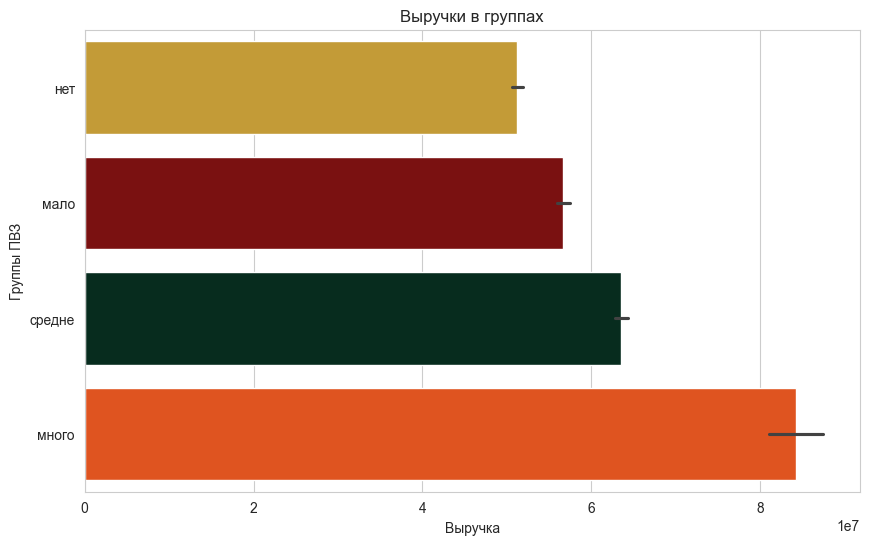

In [23]:
#барплоты пвз-выручка
plt.figure(figsize=(10,6))
sns.barplot(data=df2, y='pvz_groups',
    x='Выручка',
    order=['нет', 'мало', 'средне', 'много'],
    palette = ["#DAA520", "#8B0000", "#013220", "#FF4500"])
plt.title('Выручки в группах')
plt.ylabel('Группы ПВЗ')
plt.xlabel('Выручка')
plt.show()

5217 5813 8759 740


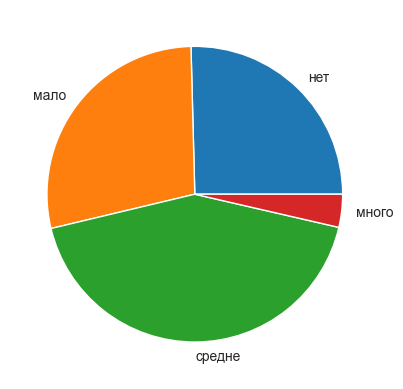

In [24]:
x  = pd.Series([df2[df2['pvz_groups'] == 'нет']['new_id'].nunique(), df2[df2['pvz_groups'] == 'мало']['new_id'].nunique(), df2[df2['pvz_groups'] == 'средне']['new_id'].nunique(), df2[df2['pvz_groups'] == 'много']['new_id'].nunique()])
y = ['нет', 'мало','средне','много']
print(df2[df2['pvz_groups'] == 'нет']['new_id'].nunique(), df2[df2['pvz_groups'] == 'мало']['new_id'].nunique(), df2[df2['pvz_groups'] == 'средне']['new_id'].nunique(), df2[df2['pvz_groups'] == 'много']['new_id'].nunique())
plt.pie(x, labels = y)
plt.show()

In [25]:
# Тест Краскела-Уоллиса (
from scipy.stats import kruskal
groups = [df2[df2['pvz_groups'] == group]['Выручка'].dropna() for group in df2['pvz_groups'].unique()]
h_stat, kruskal_p = kruskal(*groups)
print(f"Краскела-Уоллиса: H = {h_stat:.2f}, p = {kruskal_p:.6f}")

Краскела-Уоллиса: H = 896.03, p = 0.000000


In [26]:
import scikit_posthocs as sp

dunn_result = sp.posthoc_dunn(
        df2,
        val_col='Выручка',
        group_col='pvz_groups',
        p_adjust='holm'  # метод коррекции
    )
# Более читаемый формат
print("\n" + "="*60)
print("ПОПАРНЫЕ СРАВНЕНИЯ (тест Данна):")

# Преобразуем матрицу в список значимых сравнений
comparisons = []
groups = dunn_result.columns.tolist()

for i in range(len(groups)):
    for j in range(i+1, len(groups)):
        g1, g2 = groups[i], groups[j]
        p_val = dunn_result.loc[g1, g2]
        comparisons.append((g1, g2, p_val))

# Сортируем по p-value
comparisons.sort(key=lambda x: x[2])

for g1, g2, p_val in comparisons:
    symbol = "✓" if p_val < 0.05 else "✗"
    print(f"  {g1:12} vs {g2:12}: p = {p_val:.4f} {symbol} {round(df2[df2['pvz_groups'] == g1]['Выручка'].median() - df2[df2['pvz_groups'] == g2]['Выручка'].median())}")


ПОПАРНЫЕ СРАВНЕНИЯ (тест Данна):
  много        vs нет         : p = 0.0000 ✓ 28141700
  нет          vs средне      : p = 0.0000 ✓ -8934776
  мало         vs много       : p = 0.0000 ✓ -24420290
  много        vs средне      : p = 0.0000 ✓ 19206925
  мало         vs средне      : p = 0.0000 ✓ -5213365
  мало         vs нет         : p = 0.0000 ✓ 3721411


In [27]:
# Тест Краскела-Уоллиса (
from scipy.stats import kruskal

groups = [df2[df2['pvz_groups'] == group]['Трафик'].dropna() for group in df2['pvz_groups'].unique()]
h_stat, kruskal_p = kruskal(*groups)
print(f"Краскела-Уоллиса: H = {h_stat:.2f}, p = {kruskal_p:.6f}")

Краскела-Уоллиса: H = 1571.66, p = 0.000000


In [28]:
dunn_result = sp.posthoc_dunn(
        df2,
        val_col='Трафик',
        group_col='pvz_groups',
        p_adjust='holm'  # метод коррекции
    )
# Более читаемый формат
print("\n" + "="*60)
print("ПОПАРНЫЕ СРАВНЕНИЯ (тест Данна):")

# Преобразуем матрицу в список значимых сравнений
comparisons = []
groups = dunn_result.columns.tolist()

for i in range(len(groups)):
    for j in range(i+1, len(groups)):
        g1, g2 = groups[i], groups[j]
        p_val = dunn_result.loc[g1, g2]
        comparisons.append((g1, g2, p_val))

# Сортируем по p-value
comparisons.sort(key=lambda x: x[2])

for g1, g2, p_val in comparisons:
    symbol = "✓" if p_val < 0.05 else "✗"
    print(f"  {g1:12} vs {g2:12}: p = {p_val:.4f} {symbol} {round(df2[df2['pvz_groups'] == g1]['Трафик'].median() - df2[df2['pvz_groups'] == g2]['Трафик'].median())}")


ПОПАРНЫЕ СРАВНЕНИЯ (тест Данна):
  нет          vs средне      : p = 0.0000 ✓ -6157
  много        vs нет         : p = 0.0000 ✓ 15541
  мало         vs много       : p = 0.0000 ✓ -12596
  мало         vs средне      : p = 0.0000 ✓ -3211
  много        vs средне      : p = 0.0000 ✓ 9385
  мало         vs нет         : p = 0.0000 ✓ 2946


In [29]:
# Тест Краскела-Уоллиса (
from scipy.stats import kruskal
groups = [df2[df2['pvz_groups'] == group]['Средний чек'].dropna() for group in df2['pvz_groups'].unique()]
h_stat, kruskal_p = kruskal(*groups)
print(f"Краскела-Уоллиса: H = {h_stat:.2f}, p = {kruskal_p:.6f}")

Краскела-Уоллиса: H = 427.95, p = 0.000000


In [30]:
dunn_result = sp.posthoc_dunn(
        df2,
        val_col='Средний чек',
        group_col='pvz_groups',
        p_adjust='holm'  # метод коррекции
    )
# Более читаемый формат
print("\n" + "="*60)
print("ПОПАРНЫЕ СРАВНЕНИЯ (тест Данна):")

# Преобразуем матрицу в список значимых сравнений
comparisons = []
groups = dunn_result.columns.tolist()

for i in range(len(groups)):
    for j in range(i+1, len(groups)):
        g1, g2 = groups[i], groups[j]
        p_val = dunn_result.loc[g1, g2]
        comparisons.append((g1, g2, p_val))

# Сортируем по p-value
comparisons.sort(key=lambda x: x[2])

for g1, g2, p_val in comparisons:
    symbol = "✓" if p_val < 0.05 else "✗"
    print(f"  {g1:12} vs {g2:12}: p = {p_val:.4f} {symbol} {round(df2[df2['pvz_groups'] == g1]['Средний чек'].median() - df2[df2['pvz_groups'] == g2]['Средний чек'].median())}")


ПОПАРНЫЕ СРАВНЕНИЯ (тест Данна):
  много        vs нет         : p = 0.0000 ✓ 230
  нет          vs средне      : p = 0.0000 ✓ -64
  мало         vs много       : p = 0.0000 ✓ -200
  много        vs средне      : p = 0.0000 ✓ 167
  мало         vs средне      : p = 0.0000 ✓ -34
  мало         vs нет         : p = 0.0000 ✓ 30


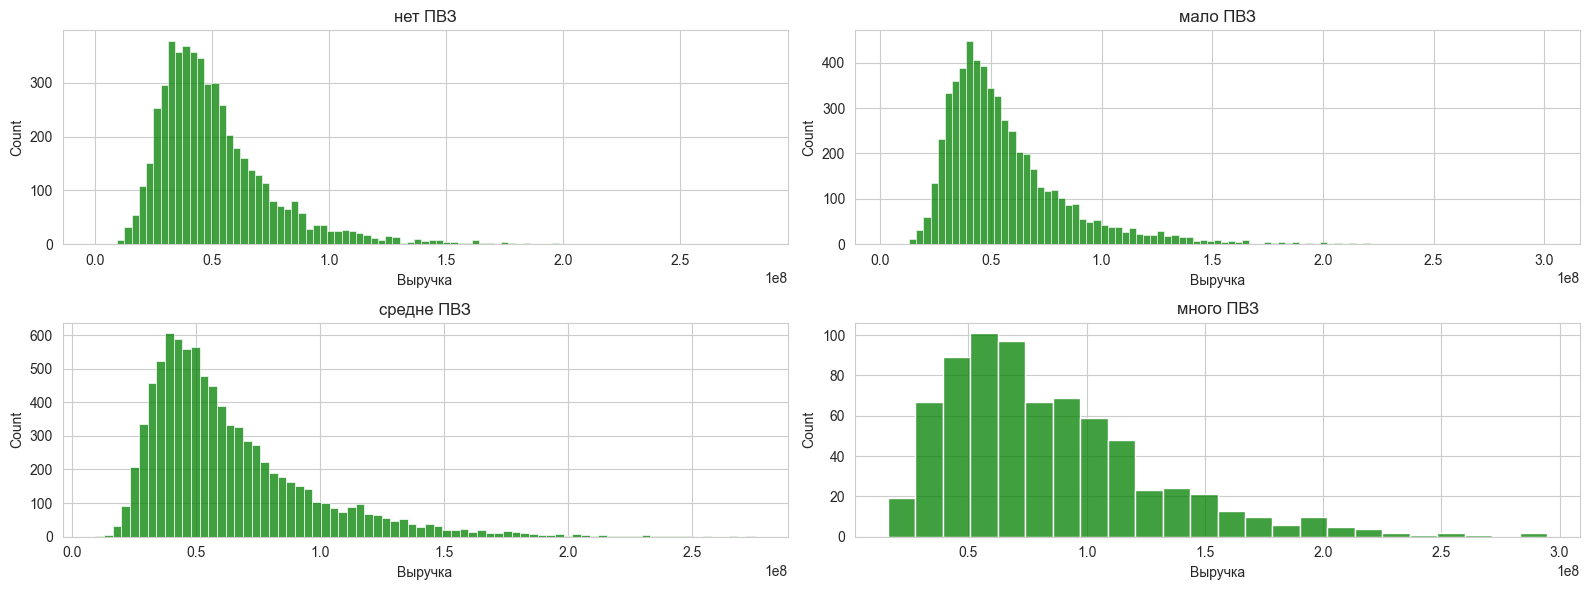

In [31]:
plt.figure(figsize=(16, 6))

plt.subplot(2,2,1)
sns.histplot(group1, color = 'green')
plt.title('нет ПВЗ')

plt.subplot(2,2,2)
sns.histplot(group2, color = 'green')
plt.title('мало ПВЗ')

plt.subplot(2,2,3)
sns.histplot(group3, color = 'green')
plt.title('средне ПВЗ')

plt.subplot(2,2,4)
sns.histplot(group4, color = 'green')
plt.title('много ПВЗ')
plt.tight_layout()
plt.show()

In [32]:
regions = data['Регион'].unique()
k_znachim = 0
k_neznacnim = 0
reg = pd.DataFrame({
    'region': regions,
    'нет': [0]*len(regions),
    'мало': [0]*len(regions),
    'средне': [0]*len(regions),
    'много': [0]*len(regions)
})
k = -1
for region in regions:
    k += 1
    if len(region) > 3:
        df = data[data['Регион'] == region]
        df = df.groupby('new_id', as_index = False).agg({'Выручка':'mean', 'Трафик':'mean','Средний чек':'mean', 'пвз':'mean'}).copy()
        df['pvz_groups'] = df['пвз'].apply(create_pvs_categories)
        groups = [df[df['pvz_groups'] == group]['Выручка'].dropna() for group in df['pvz_groups'].unique()]
        j = 0
        for gr in ['нет','мало','средне','много']:
            j += 1
            try:
                reg.iat[k, j] = len(df[df['pvz_groups'] == gr]['Выручка'])
            except:
                reg.iat[k, j] = 0
        if len(groups) > 2:
            h_stat, kruskal_p = kruskal(*groups)
            if kruskal_p < 0.05:
                print(f'{region}: p-value значим {kruskal_p}')
                k_znachim += 1
            else:
                print(f'{region}: p-value незначим {kruskal_p}')
                k_neznacnim += 1
        else:
            print(f'{region}: другой тест нужен')
    else:
        print(f'{region}: кол-во наблюдений {len(region)}')

print(f'кол-во значимых отличий: {k_znachim}, кол-во незначимых {k_neznacnim}')

Краснодарский край: p-value значим 1.852003956386225e-05
Свердловская обл: p-value значим 1.955184357769703e-06
Московская обл: p-value значим 4.039495715777608e-18
Москва г: p-value значим 1.1841290656804979e-11
Нижегородская обл: p-value значим 1.9049568127441957e-09
Марий Эл Респ: p-value незначим 0.7643337382727025
Псковская обл: p-value значим 0.0024317453871117653
Владимирская обл: p-value значим 0.00015342938320926045
Самарская обл: p-value значим 0.00013839684922831142
Ростовская обл: p-value значим 0.0005727897957469987
Ивановская обл: p-value незначим 0.14480260853405197
Пермский край: p-value значим 0.0005529112692018827
Костромская обл: p-value значим 0.031859828410452797
Архангельская обл: p-value значим 0.038771292910568536
Курская обл: p-value значим 0.009418129235530481
Челябинская обл: p-value значим 2.3067517390248794e-09
Татарстан Респ: p-value значим 2.1643655355029532e-07
Карелия Респ: p-value незначим 0.19975512217232685
Тамбовская обл: p-value незначим 0.64017559

In [33]:
kvar1 = [1,2,3]
kvar2 = [4,5,6]
kvar3 = [7,8,9]
kvar4 = [10,11,12]
k_znachim = 0
k_neznacnim = 0
kvr = pd.DataFrame({
    'kvartal': ['1 квартал','2 квартал','3 квартал','4 квартал'],
    'нет': [0]*4,
    'мало': [0]*4,
    'средне': [0]*4,
    'много': [0]*4
})
kv = [kvar1,kvar2,kvar3,kvar4]
j = 0
k = -1
for i in kv:
    k += 1
    j += 1
    df = data[data['Месяц'].isin(i)]
    df = df.groupby('new_id', as_index = False).agg({'Выручка':'mean', 'Трафик':'mean','Средний чек':'mean', 'пвз':'mean'}).copy()
    df['pvz_groups'] = df['пвз'].apply(create_pvs_categories)
    groups = [df[df['pvz_groups'] == group]['Выручка'].dropna() for group in df['pvz_groups'].unique()]
    if len(groups) > 2:
            h_stat, kruskal_p = kruskal(*groups)
            t = 0
            for gr in ['нет','мало','средне','много']:
                t += 1
                try:
                    kvr.iat[k, t] = len(df[df['pvz_groups'] == gr]['Выручка'])
                except:
                    kvr.iat[k, t] = 0
            if kruskal_p < 0.05:
                print(f'квартал {j}: p-value значим {kruskal_p}')
                k_znachim += 1
            else:
                print(f'{i}: p-value незначим {kruskal_p}')
                k_neznacnim += 1
    else:
            print(f'{i}: другой тест нужен')

print(f'кол-во значимых отличий: {k_znachim}, кол-во незначимых {k_neznacnim}')

квартал 1: p-value значим 2.2334135611861807e-241
квартал 2: p-value значим 4.8989950795461166e-172
квартал 3: p-value значим 6.995584831732028e-131
квартал 4: p-value значим 1.1490733792238716e-216
кол-во значимых отличий: 4, кол-во незначимых 0


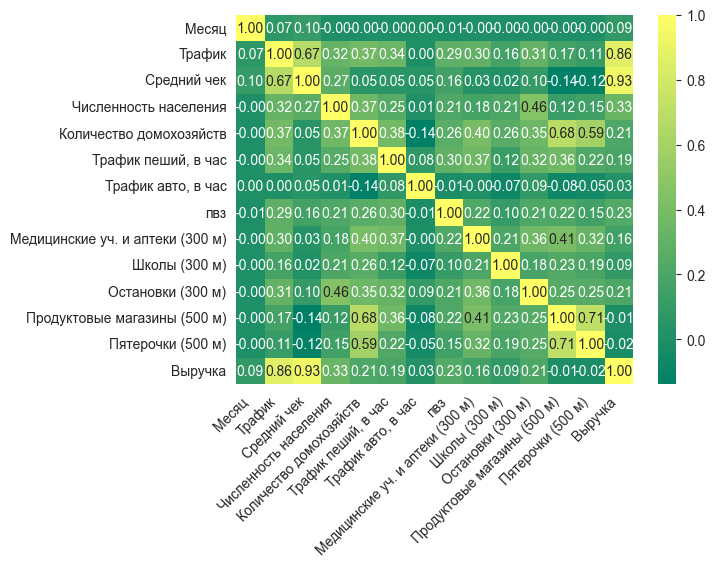

In [34]:
clear = data[['Месяц', 'Трафик', 'Средний чек', 'Численность населения', 'Количество домохозяйств', 'Трафик пеший, в час','Трафик авто, в час'\
              ,'пвз', 'Медицинские уч. и аптеки (300 м)', 'Школы (300 м)', 'Остановки (300 м)', 'Продуктовые магазины (500 м)', 'Пятерочки (500 м)', 'Выручка']]
correlation_matrix = clear.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='summer', fmt='.2f')
plt.xticks(rotation=45, ha='right')
plt.show()